In [201]:
#!pip install optuna
import pandas as pd
import pickle
import datetime
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import matplotlib.pyplot as pit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
from torch import nn
# from google.colab import drive

# exports
def plot_calibration_curve(named_classifiers, X_test, y_test):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="完全な補正")
    for name, clf in named_classifiers.items():
        prob_pos = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_pos)
        brier = brier_score_loss(y_test, prob_pos)
        print("%s:" % name)
        print("\tAUC  : %1.3f" % auc)
        print("\tBrier: %1.3f" % (brier))
        print()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test,
            prob_pos,
            n_bins=10,
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label="%s (%1.3f)" % (name, brier),
        )

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

    ax1.set_ylabel("正例の比率")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title("信頼性曲線")

    ax2.set_xlabel("予測値の平均")
    ax2.set_ylabel("サンプル数")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

def preprocessing(results, kako=5):
    df = results.copy()

    df.drop([
        'compi',
        'compi_num', 
        "speed", 
        'rank', '気温', '風速', '風向',
'1走前着差', '2走前着差', '3走前着差', '4走前着差', '5走前着差',
'1走前スピードZI','2走前スピードZI', '3走前スピードZI','4走前スピードZI', '5走前スピードZI',
'1走前スピード指数','2走前スピード指数', '3走前スピード指数','4走前スピード指数', '5走前スピード指数',
'1走前コンピ指数','2走前コンピ指数', '3走前コンピ指数','4走前コンピ指数', '5走前コンピ指数',
'1走前コンピ順位','2走前コンピ順位', '3走前コンピ順位','4走前コンピ順位', '5走前コンピ順位',
'1走前走破タイム', '2走前走破タイム', '3走前走破タイム', '4走前走破タイム', '5走前走破タイム',
'1走前補正タイム', '2走前補正タイム', '3走前補正タイム', '4走前補正タイム', '5走前補正タイム',
'1走前結果', '2走前結果', '3走前結果', '4走前結果', '5走前結果',
'1走前オッズ', '2走前オッズ', '3走前オッズ', '4走前オッズ', '5走前オッズ',
        'horse_race_id',  'body_weight','body_weight_in_de',

    ], axis=1, inplace=True)
    df['date'] = df['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    df = df.sort_values(by='date', ascending = False)
    df = df.set_index('race_id')
    return df

def split_data(df, test_size=0.3, place=None):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]

    train = df.loc[train_ids]
    test = df.loc[test_ids]
    
    return train, test

def train_valid_split_data(df, test_size=0.3):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]
    
    train = df.loc[train_ids]
    valid = df.loc[test_ids]
    
    return train, valid

def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    # df2 = pd.get_dummies(df2, sparse=True)
    df2 = pd.get_dummies(df2)
    for column in target_columns:
        df2[column] = df2[column].astype('category')
        
    return df2

class TimeModel:
    def __init__(self, model, base_data):
        self.model = model
        self.base_data = base_data
        
    def pred_time(self, X):
        pred_time = self.base_data.copy()[['id', 'popular']]
        actual_table = X.copy()[['id', 'h_num', 'place_id']]

        X = X.drop(['id'], axis=1)
        actual_table['pred_time'] = model.predict(X)

        actual_table = actual_table.reset_index()
        pred_time = pred_time.reset_index()
        actual = pred_time.merge(actual_table, left_index=True, right_index=True, how='right')
        actual.drop(['id_x', 'id_y', 'race_id_y'], axis=1, inplace=True)

        return actual
    
    def race_pred_time(self, X):
        actual = self.pred_time(X)
        groups = actual.groupby('race_id_x').groups
        column_list = ["h_num", 'pred_time', 'popular']

        new_df = pd.DataFrame()
        max_length = 0
        for group, indexes in groups.items():
            # 最後に並び替えをさせるのに最大作成された項目数を記録
            length = len(indexes)+1
            if length > max_length:
                max_length = length

            columns = list()
            values = list()
            columns += ['race_id', 'place_id']
            values += [actual.iloc[indexes]['race_id_x'].T.tolist()[0], actual.iloc[indexes]['place_id'].T.tolist()[0]]

            for target_column in column_list:
                columns += [f'{target_column}_{x}' for x in range(1, length)]
                sort_values = actual.iloc[indexes, :].sort_values(by='pred_time', ascending = False)
                values += sort_values[target_column].T.tolist()

            record_df = pd.DataFrame([values], columns=columns)
            new_df = pd.concat([new_df, record_df], axis=0)

        return new_df

class ModelEvaluator:
    def __init__(self, model, haitou_table, std = True):
        self.model = model
        self.haitou = haitou_table
        self.std = std
        self.pp = None
        
    def predict_proba(self, X, std=True):
#         proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        if self.pp is not None:
          return self.pp

        proba = pd.Series(self.model.predict_proba(X.drop(['id', 'odds'], axis=1))[:, 1], index=X.index)
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
            
        self.pp = proba
        return proba
    
    def prefict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def win_ratio(self, X):
        sum1 = pd.DataFrame(self.predict_proba(X).groupby(level=0).sum())
        y_pred = self.predict_proba(X)

        return [(p / sum1.loc[i])[0] for i, p in y_pred.items()]
    
    def score(self, y_true, X):
        proba = self.predict_proba(X, True)
        n = lambda x: 0.0 if np.isnan(x) else x
        proba = proba.map(n)
        return roc_auc_score(y_true, proba)
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['h_num', 'odds']]
        pred_table['pred'] = self.prefict(X, threshold)
        pred_table['win_ratio'] = self.win_ratio(X)
        if bet_only:
            pred_table = pred_table[pred_table['pred'] == 1][['h_num', 'odds', 'win_ratio']]
#             pred_table = pred_table[pred_table['pred'] == 1][['h_num', 'odds', 'time_odds']]
            return pred_table
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        haitou = self.haitou.copy()
        df = haitou.merge(pred_table, left_index=True, right_index=True, how='right')

        n_hits = len(df[df['1着馬番'] == df['h_num']]) + len(df[df['2着馬番'] == df['h_num']]) + len(df[df['3着馬番'] == df['h_num']]) + len(df[df['4着馬番'] == df['h_num']])
        for i in range(1, 5):
            money += df[df[str(i) + '着馬番'] == df['h_num']]['複勝' + str(i)].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate,n_hits
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        df['単勝配当'] = df['単勝'].astype(int)
        
#         std = ((df['1着馬番'] ==  df['h_num']) * df['単勝配当'])\
#         .groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
        n_hits = len(df[df['1着馬番'] == df['h_num']])
        
        money += df[df['1着馬番'] == df['h_num']]['単勝配当'].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate, n_hits
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        bet_money = (1/pred_table['odds']).sum()
        std = ((df['1着馬番'] == df['h_num']).astype(int)).groupby(level=0).sum().std() * np.sqrt(n_races) / bet_money
        
        df['h_num'] = df['h_num'].astype(float)
        df['馬番_1'] = df['1着馬番']
        n_hits = len(df.query('馬番_1 == h_num'))
        return_rate = n_hits/bet_money
        return n_bets, return_rate, n_hits
        
    
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        # 閾値を増やす        
        threshold = 1 * i /n_samples + min_threshold * (1 - i/n_samples)
        n_bets, return_rate, n_hits = return_func(X, threshold)
        if n_bets == 0:
            break;
        if n_bets > lower:
            gain[n_bets] = { 'return_rate': return_rate, 'n_hits': n_hits }
    return pd.DataFrame(gain).T

In [388]:
df = pd.read_pickle('./pickle_new/chihou/chihou_race_detail.pickle')
j = pd.read_pickle('./pickle_new/chihou/jockey_rate.pickle')
s = pd.read_pickle('./pickle_new/chihou/horse_stallion_rate.pickle')
df = df.merge(j, how='left', on='id')
df = df.merge(s, how='left', on=['race_id', 'stallion_id'])

# df = df.query('(place_id == 42)|(place_id == 43)|(place_id == 44)|(place_id == 45)')
df['date'] = df['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df.drop(['1走前オッズ', '2走前オッズ','3走前オッズ','4走前オッズ','5走前オッズ'], axis=1, inplace=True)

df = df.sort_values(by='date', ascending = False)
all_r = df.set_index('race_id')
all_r = all_r.fillna({
'1走前騎手ID': 0, '1走前距離': 0, '1走前場所': 0,'1走前コース': 0,
'2走前騎手ID': 0, '2走前距離': 0, '2走前場所': 0,'2走前コース': 0,
'3走前騎手ID': 0, '3走前距離': 0, '3走前場所': 0,'3走前コース': 0,
'4走前騎手ID': 0, '4走前距離': 0, '4走前場所': 0,'4走前コース': 0,
'5走前騎手ID': 0, '5走前距離': 0, '5走前場所': 0,'5走前コース': 0,
})

all_r['result'] = all_r['result'].map(lambda x: 1 if x == 1 else 0)

categorical = process_categorical(all_r, [
    'owner',  'course',
    'jockey_id', 'gender', 'trainer_id', 'weight',
    'grade', 'age', 'place_id',
    'stallion_id', 'affiliation_id',
    '1走前騎手ID', '1走前場所', '1走前距離', '1走前コース',
    '2走前騎手ID', '2走前場所', '2走前距離', '2走前コース',
    '3走前騎手ID', '3走前場所', '3走前距離', '3走前コース',
    '4走前騎手ID', '4走前場所', '4走前距離', '4走前コース',
    '5走前騎手ID', '5走前場所', '5走前距離', '5走前コース',
])
vec = pd.read_pickle('./pickle_new/peds_vec.pickle')
# vec = vec[[
#     'horse_id', "peds_1","peds_2","peds_3","peds_4","peds_5",
#     "peds_6","peds_7","peds_8","peds_9","peds_10",
#     "peds_11","peds_12","peds_13","peds_14"
# ]]

categorical = categorical.reset_index()
categorical = categorical.merge(vec, on='horse_id')
categorical = categorical.set_index('race_id')

train1, valid1 = split_data(categorical)
valid1, test1 = train_valid_split_data(valid1)

In [258]:
X_train1 = train1.drop(['id', 'date', 'body_weight','body_weight_in_de','result', 'odds', 'popular', 'horse_id'], axis=1)
y_train1 = train1['result']
X_valid1 = valid1.drop(['date', 'body_weight','body_weight_in_de','result', 'popular',  'horse_id'], axis=1)
y_valid1 = valid1['result']
X_test1 = test1.drop(['date','body_weight','body_weight_in_de', 'result', 'popular',  'horse_id'], axis=1)
y_test1 = test1['result']

In [259]:
import optuna.integration.lightgbm as lgb_o

lgb_train = lgb_o.Dataset(X_train1.values, y_train1.values)
lgb_valid = lgb_o.Dataset(X_valid1.values, y_valid1.values)

params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-11-02 21:52:06,753] A new study created in memory with name: no-name-57b6942c-17d2-44a8-931e-beabd3ab9ef6
feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.298801:  14%|#########                                                      | 1/7 [00:20<01:59, 19.98s/it]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.269701	valid_1's binary_logloss: 0.298801
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.298801:  29%|##################                                             | 2/7 [00:38<01:36, 19.21s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.274966	valid_1's binary_logloss: 0.315324
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.298801:  43%|###########################                                    | 3/7 [00:49<01:01, 15.47s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.301085	valid_1's binary_logloss: 0.319745
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.298801:  57%|####################################                           | 4/7 [01:00<00:40, 13.62s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.30092	valid_1's binary_logloss: 0.320186
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.298801:  71%|#############################################                  | 5/7 [01:14<00:27, 13.59s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.278415	valid_1's binary_logloss: 0.319007
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.519492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.298801:  86%|######################################################         | 6/7 [01:26<00:13, 13.23s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.282821	valid_1's binary_logloss: 0.318637
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.515066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.298801: 100%|###############################################################| 7/7 [01:37<00:00, 13.87s/it]


Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.301083	valid_1's binary_logloss: 0.319895


num_leaves, val_score: 0.298801:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:   5%|###4                                                                | 1/20 [00:12<04:03, 12.80s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.271956	valid_1's binary_logloss: 0.318432
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  10%|######8                                                             | 2/20 [00:23<03:30, 11.68s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.292325	valid_1's binary_logloss: 0.319246
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  15%|##########2                                                         | 3/20 [00:34<03:13, 11.38s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.284904	valid_1's binary_logloss: 0.318746
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  20%|#############6                                                      | 4/20 [00:46<03:01, 11.36s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.280133	valid_1's binary_logloss: 0.316977
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  25%|#################                                                   | 5/20 [00:59<03:02, 12.14s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.269417	valid_1's binary_logloss: 0.317247
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  30%|####################4                                               | 6/20 [01:18<03:20, 14.34s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.262968	valid_1's binary_logloss: 0.30842
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  35%|#######################7                                            | 7/20 [01:36<03:21, 15.50s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.267308	valid_1's binary_logloss: 0.31739
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  40%|###########################2                                        | 8/20 [01:50<03:01, 15.09s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.282078	valid_1's binary_logloss: 0.318934
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  45%|##############################6                                     | 9/20 [02:04<02:43, 14.90s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.279929	valid_1's binary_logloss: 0.317629
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  50%|#################################5                                 | 10/20 [02:18<02:24, 14.46s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.276141	valid_1's binary_logloss: 0.317009
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  55%|####################################8                              | 11/20 [02:32<02:08, 14.27s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.276995	valid_1's binary_logloss: 0.31449
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  60%|########################################1                          | 12/20 [02:50<02:05, 15.68s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.267999	valid_1's binary_logloss: 0.299398
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  65%|###########################################5                       | 13/20 [03:01<01:37, 13.98s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.283998	valid_1's binary_logloss: 0.319723
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  70%|##############################################9                    | 14/20 [03:11<01:17, 12.95s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.280936	valid_1's binary_logloss: 0.318108
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  75%|##################################################2                | 15/20 [03:24<01:04, 12.85s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.272413	valid_1's binary_logloss: 0.314184
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  80%|#####################################################6             | 16/20 [03:32<00:45, 11.39s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.316241	valid_1's binary_logloss: 0.320781
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  85%|########################################################9          | 17/20 [03:47<00:37, 12.43s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.266517	valid_1's binary_logloss: 0.313143
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  90%|############################################################3      | 18/20 [04:02<00:26, 13.23s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.269506	valid_1's binary_logloss: 0.301335
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801:  95%|###############################################################6   | 19/20 [04:13<00:12, 12.71s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.277079	valid_1's binary_logloss: 0.315339
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.298801: 100%|###################################################################| 20/20 [04:29<00:00, 13.46s/it]


Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.272746	valid_1's binary_logloss: 0.30137


bagging, val_score: 0.298801:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.298801:  10%|#######1                                                               | 1/10 [00:09<01:24,  9.35s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.281741	valid_1's binary_logloss: 0.316704
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  20%|##############2                                                        | 2/10 [00:24<01:44, 13.03s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.271529	valid_1's binary_logloss: 0.295805
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  30%|#####################3                                                 | 3/10 [00:32<01:14, 10.69s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.315447	valid_1's binary_logloss: 0.321045
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  40%|############################4                                          | 4/10 [00:41<00:58,  9.70s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.315467	valid_1's binary_logloss: 0.320318
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  50%|###################################5                                   | 5/10 [00:54<00:55, 11.02s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.272377	valid_1's binary_logloss: 0.306958
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  60%|##########################################6                            | 6/10 [01:02<00:40, 10.05s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.315495	valid_1's binary_logloss: 0.322616
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  70%|#################################################6                     | 7/10 [01:10<00:28,  9.43s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.315479	valid_1's binary_logloss: 0.322594
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  80%|########################################################8              | 8/10 [01:25<00:22, 11.18s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.272387	valid_1's binary_logloss: 0.308334
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805:  90%|###############################################################9       | 9/10 [01:41<00:12, 12.72s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.270946	valid_1's binary_logloss: 0.301834
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.295805: 100%|######################################################################| 10/10 [01:50<00:00, 11.00s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.315471	valid_1's binary_logloss: 0.320398


feature_fraction_stage2, val_score: 0.295805:   0%|                                                                | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.295805:  33%|##################6                                     | 1/3 [00:10<00:20, 10.32s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.286189	valid_1's binary_logloss: 0.319119
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.293675:  67%|#####################################3                  | 2/3 [00:28<00:15, 15.04s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293675
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.293675: 100%|########################################################| 3/3 [00:44<00:00, 14.67s/it]


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.272195	valid_1's binary_logloss: 0.300264


regularization_factors, val_score: 0.293675:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.293675:   5%|##8                                                     | 1/20 [00:16<05:10, 16.35s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.272016	valid_1's binary_logloss: 0.303778
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.293675:  10%|#####6                                                  | 2/20 [00:28<04:04, 13.58s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.281738	valid_1's binary_logloss: 0.318104
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.293675:  15%|########4                                               | 3/20 [00:45<04:24, 15.57s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293675
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.293675:  20%|###########2                                            | 4/20 [00:57<03:40, 13.80s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.28079	valid_1's binary_logloss: 0.31636
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.293675:  25%|##############                                          | 5/20 [01:14<03:49, 15.27s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293675
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.293675:  30%|################8                                       | 6/20 [01:27<03:18, 14.20s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.278413	valid_1's binary_logloss: 0.316672
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.293675:  35%|###################5                                    | 7/20 [01:44<03:20, 15.40s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293678
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.268002	valid_1's binary_logloss: 0.296131


regularization_factors, val_score: 0.292929:  40%|######################4                                 | 8/20 [02:06<03:28, 17.39s/it]

Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.267073	valid_1's binary_logloss: 0.292929
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.292929:  45%|#########################2                              | 9/20 [02:28<03:27, 18.86s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293675
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.292929:  50%|###########################5                           | 10/20 [02:48<03:12, 19.21s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293675
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.292929:  55%|##############################2                        | 11/20 [03:00<02:32, 16.90s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.278379	valid_1's binary_logloss: 0.317598
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  60%|#################################                      | 12/20 [03:19<02:21, 17.63s/it]

[100]	valid_0's binary_logloss: 0.267933	valid_1's binary_logloss: 0.292535
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.268973	valid_1's binary_logloss: 0.290283
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  65%|###################################7                   | 13/20 [03:37<02:03, 17.63s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.271893	valid_1's binary_logloss: 0.300883
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  70%|######################################5                | 14/20 [03:52<01:41, 16.96s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.273246	valid_1's binary_logloss: 0.301275
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  75%|#########################################2             | 15/20 [04:12<01:29, 17.95s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293677
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  80%|############################################           | 16/20 [04:25<01:04, 16.23s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.280221	valid_1's binary_logloss: 0.317273
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  85%|##############################################7        | 17/20 [04:45<00:52, 17.59s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.269992	valid_1's binary_logloss: 0.296591
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  90%|#################################################5     | 18/20 [05:05<00:36, 18.09s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293677
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283:  95%|####################################################2  | 19/20 [05:25<00:18, 18.66s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.270058	valid_1's binary_logloss: 0.293675
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.290283: 100%|#######################################################| 20/20 [05:45<00:00, 17.29s/it]


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.269237	valid_1's binary_logloss: 0.297747


min_data_in_leaf, val_score: 0.290283:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.290283:  20%|############6                                                  | 1/5 [00:11<00:45, 11.44s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.281721	valid_1's binary_logloss: 0.31816
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.290283:  40%|#########################2                                     | 2/5 [00:24<00:37, 12.50s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.278378	valid_1's binary_logloss: 0.317594
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.290283:  60%|#####################################8                         | 3/5 [00:37<00:25, 12.72s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.278378	valid_1's binary_logloss: 0.317598
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.268136	valid_1's binary_logloss: 0.302479


min_data_in_leaf, val_score: 0.290283:  80%|##################################################4            | 4/5 [01:00<00:16, 16.84s/it]

Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.26742	valid_1's binary_logloss: 0.298545
[LightGBM] [Info] Number of positive: 54703, number of negative: 497981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098977 -> initscore=-2.208643
[LightGBM] [Info] Start training from score -2.208643
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.290283: 100%|###############################################################| 5/5 [01:13<00:00, 14.66s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.278378	valid_1's binary_logloss: 0.3176


In [260]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 9.579887367998411e-07,
 'lambda_l2': 0.003442774081046108,
 'num_leaves': 31,
 'feature_fraction': 0.44800000000000006,
 'bagging_fraction': 0.9330618671023129,
 'bagging_freq': 4,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [269]:
import lightgbm as lgb

params = {
 'objective': 'binary',
'random_state': 100,
'feature_pre_filter': False,
 'lambda_l1': 1.6698020366638395,
 'lambda_l2': 5.0660659894978455,
 'num_leaves': 168,
 'feature_fraction': 0.62,
 'bagging_fraction': 0.9436453052101297,
 'bagging_freq': 1,
 'min_child_samples': 10,
 'num_iterations': 1000,
}

lgb_clf1 = lgb.LGBMClassifier(**params)
lgb_clf1.fit(X_train1.values, y_train1.values)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.62, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.62
[LightGBM] [Warning] bagging_fraction is set=0.9436453052101297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9436453052101297
[LightGBM] [Warning] lambda_l2 is set=5.0660659894978455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0660659894978455
[LightGBM] [Warning] lambda_l1 is set=1.6698020366638395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6698020366638395


LGBMClassifier(bagging_fraction=0.9436453052101297, bagging_freq=1,
               feature_fraction=0.62, feature_pre_filter=False,
               lambda_l1=1.6698020366638395, lambda_l2=5.0660659894978455,
               min_child_samples=10, num_iterations=1000, num_leaves=168,
               objective='binary', random_state=100)

In [5]:
haitou = pd.read_csv('./csv_new2/chihou/chihou_haitou.csv')
haitou = haitou.set_index('race_id')

/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_39183/708840992.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  haitou = pd.read_csv('./csv_new2/chihou/chihou_haitou.csv')


In [270]:
me_valid = ModelEvaluator(lgb_clf1, haitou, std=True)
me_valid.score(y_valid1, X_valid1)

0.7772391842882118

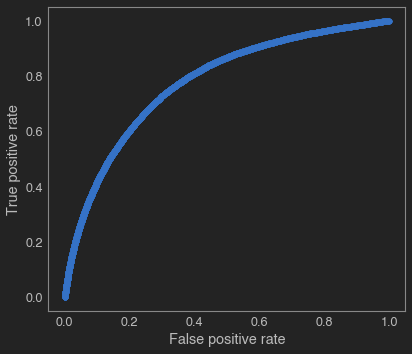

In [271]:
from jupyterthemes import jtplot

y_pred = me_valid.predict_proba(X_valid1).values

jtplot.style(theme='monokai')

fpr, tpr, thresholds = roc_curve(y_valid1, y_pred)
pit.plot(fpr, tpr, marker='o')
pit.xlabel("False positive rate")
pit.ylabel("True positive rate")
pit.grid()
pit.show()

In [272]:
me_valid.feature_importance(X_train1, 50)

,features,importance
33,1走前上がり3F,1544
27,1走前走破タイム,1428
59,2走前走破タイム,1421
10,trainer_id,1375
35,1走前馬場指数,1367
28,1走前着差,1327
156,5走前走破タイム,1299
17,owner,1295
92,3走前走破タイム,1281
132,4走前馬場指数,1252


In [284]:
me_valid = ModelEvaluator(lgb_clf1, haitou, std=True)
wr = me_valid.pred_table(X_valid1, 0.7, True)
wr['pred_rank'] = wr[['win_ratio']].groupby(level=0).rank(ascending=False)
wr['expected'] = wr['win_ratio'] * wr['odds']

In [285]:
bt = wr[
    wr['expected'] < 1
]
# bt = wr

In [286]:
bh = bt.merge(haitou, on='race_id')

print("点数：{} レース出現確率:{:.1%} 賭金:{:,}円 配当合計:{:,}円 最高配当:{:,}円 的中数:{} 的中率:{:.1%} 回収率:{:.1%}". format(
    len(bt),\
    len(bt.groupby(level=0)) / len(X_valid1.groupby(level=0)),\
    len(bt) * 100,\
    int(bh[bh['h_num'] == bh['1着馬番']]['単勝'].sum()),\
    int(bh[bh['h_num'] == bh['1着馬番']]['単勝'].max()),\
    len(bh[bh['h_num'] == bh['1着馬番']]),\
    len(bh[bh['h_num'] == bh['1着馬番']]) / (len(bt)),\
    (bh[bh['h_num'] == bh['1着馬番']]['単勝'].sum() / (len(bt) * 100)), \
))

点数：9336 レース出現確率:56.2% 賭金:933,600円 配当合計:765,920円 最高配当:750円 的中数:3989 的中率:42.7% 回収率:82.0%


In [287]:
h = bt.merge(haitou, on='race_id')

money = 0
f_c = 0
for i in range(1, 5):
    s = str(i)
    f_c += len(h[h['h_num'] == h[s + '着馬番']]['複勝' + s])
    money += h[h['h_num'] == h[s + '着馬番']]['複勝' + s].sum()

print("賭金:{:,}円 配当合計:{:,}円 的中数:{} 的中率:{:.1%} 回収率:{:.1%}". format(
    (len(bt) * 100),\
    int(money),\
    f_c,\
    f_c / len(bt),\
    (money / (len(bt) * 100))
))

賭金:933,600円 配当合計:816,800円 的中数:6851 的中率:73.4% 回収率:87.5%


In [293]:
import torch
from torch import nn

cc = categorical.copy()
result_d = cc.fillna(0)

train1_d, valid1_d  = split_data(result_d)
valid1_d, test1_d  = train_valid_split_data(valid1_d)

X_train1_d  = train1_d.drop(['id', 'date', 'result', 'odds', 'popular', 'horse_id'], axis=1)
t_train1_d  = train1_d['result']
X_valid1_d  = valid1_d.drop(['id', 'date', 'result', 'horse_id'], axis=1)
t_valid1_d  = valid1_d['result']

X_train_d = torch.Tensor(X_train1_d.values)
t_train_d = torch.Tensor(t_train1_d.values)
X_valid_d = torch.Tensor(X_valid1_d.drop(['odds', 'popular'], axis=1).values)
t_valid_d = torch.Tensor(t_valid1_d.values)

t_train_d = t_train_d.reshape([-1, 1])
t_valid_d = t_valid_d.reshape([-1, 1])

X_test1_d = test1.drop(['id', 'date', 'result', 'horse_id'], axis=1)
t_test1_d = test1['result']
X_test_d = torch.Tensor(X_test1_d.drop(['odds', 'popular'], axis=1).values)
t_test_d = torch.Tensor(t_test1_d.values)

t_test_d = t_test_d.reshape([-1, 1])

In [294]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_d, t_train_d)
loader = DataLoader(dataset, batch_size=290, shuffle=True)

from torch import optim

model = nn.Sequential(
    nn.Linear(290, 128),
    nn.BatchNorm1d(128),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(80):
    model.train()

    for X, t in loader:
        optimizer.zero_grad()
        y = model(X)
        loss = loss_fn(y, t)
        # 傾きの計算
        loss.backward()
        # optimizerの更新
        optimizer.step()
        
    model.eval()
    y_train_d = model(X_train_d)
    y_valid_d = model(X_valid_d)
   #  平均二乗誤差 予測値と正解値の誤差の計算
    loss_train = loss_fn(y_train_d, t_train_d)
    loss_valid = loss_fn(y_valid_d, t_valid_d)
    auc_train = roc_auc_score(t_train_d.detach().numpy(), y_train_d.detach().numpy())
    auc_valid = roc_auc_score(t_valid_d.detach().numpy(), y_valid_d.detach().numpy())
    
    print('epoch: {}, train:[loss={:.3f}, AUC={:.3f}], test:[loss={:.3f}, AUC={:.3f}]'.  format(epoch, loss_train, auc_train, loss_valid, auc_valid))

epoch: 0, train:[loss=0.088, AUC=0.721], test:[loss=0.088, AUC=0.714]
epoch: 1, train:[loss=0.082, AUC=0.736], test:[loss=0.082, AUC=0.736]
epoch: 2, train:[loss=0.082, AUC=0.742], test:[loss=0.082, AUC=0.738]
epoch: 3, train:[loss=0.083, AUC=0.736], test:[loss=0.082, AUC=0.732]
epoch: 4, train:[loss=0.082, AUC=0.745], test:[loss=0.082, AUC=0.743]
epoch: 5, train:[loss=0.082, AUC=0.743], test:[loss=0.083, AUC=0.735]
epoch: 6, train:[loss=0.083, AUC=0.750], test:[loss=0.082, AUC=0.749]
epoch: 7, train:[loss=0.083, AUC=0.751], test:[loss=0.083, AUC=0.749]
epoch: 8, train:[loss=0.082, AUC=0.752], test:[loss=0.082, AUC=0.750]
epoch: 9, train:[loss=0.083, AUC=0.748], test:[loss=0.083, AUC=0.747]
epoch: 10, train:[loss=0.088, AUC=0.745], test:[loss=0.088, AUC=0.743]
epoch: 11, train:[loss=0.084, AUC=0.753], test:[loss=0.084, AUC=0.753]
epoch: 12, train:[loss=0.081, AUC=0.753], test:[loss=0.081, AUC=0.752]
epoch: 13, train:[loss=0.081, AUC=0.753], test:[loss=0.081, AUC=0.751]
epoch: 14, train

In [295]:
x = valid1[['h_num', 'odds', 'popular']]
t_pred_d = pd.Series(np.around(torch.flatten(y_valid_d).detach().numpy(), decimals=5), index=x.index)
sum1 = pd.DataFrame(t_pred_d.groupby(level=0).sum())

x['proba'] = t_pred_d
proba = x[['proba']]
standard_scaler = lambda x: (x - x.mean()) / x.std()
proba = proba.groupby(level=0).transform(standard_scaler)
proba = (proba - proba.min()) / (proba.max() - proba.min())

x['proba'] = proba
x['pred'] = x['proba'].map(lambda x: 0 if x <= 0.7 else 1)
x['win_ratio'] = [(p / sum1.loc[i])[0] for i, p in t_pred_d.items()]
x['expected'] = x['odds'] * x['win_ratio']

/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_39183/769717037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['proba'] = t_pred_d
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_39183/769717037.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['proba'] = proba
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_39183/769717037.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [367]:
bt1 = x[
    (x['pred'] == 1)
    &
    (x['expected'] < 1)
]
bt1

,h_num,odds,popular,proba,pred,win_ratio,expected
race_id,,,,,,,
2020121645110309,2,1.7,1,0.781984,1,0.268949,0.457213
2020121650000003,4,3.3,1,0.758078,1,0.206049,0.679962
2020121645110307,1,2.1,1,0.807324,1,0.264423,0.555287
2020121647140302,6,1.2,1,0.753260,1,0.351716,0.422059
2020121647140304,6,1.8,1,0.763505,1,0.427313,0.769164
...,...,...,...,...,...,...,...
2022041348010410,3,1.4,1,0.843135,1,0.333341,0.466677
2022041343010302,7,4.3,3,0.711983,1,0.150113,0.645487
2022041343010302,1,4.1,2,0.712035,1,0.150125,0.615513


In [368]:
bh1 = bt1.merge(haitou, on='race_id')

print("点数：{} レース出現確率:{:.1%} 賭金:{:,}円 配当合計:{:,}円 最高配当:{:,}円 的中数:{} 的中率:{:.1%} 回収率:{:.1%}". format(
    len(bt1),\
    len(bt1.groupby(level=0)) / len(X_valid1_d.groupby(level=0)),\
    len(bt1) * 100,\
    int(bh1[bh1['h_num'] == bh1['1着馬番']]['単勝'].sum()),\
    int(bh1[bh1['h_num'] == bh1['1着馬番']]['単勝'].max()),\
    len(bh1[bh1['h_num'] == bh1['1着馬番']]),\
    len(bh1[bh1['h_num'] == bh1['1着馬番']]) / (len(bt1)),\
    (bh1[bh1['h_num'] == bh1['1着馬番']]['単勝'].sum() / (len(bt1) * 100)), \
))

点数：8741 レース出現確率:52.3% 賭金:874,100円 配当合計:671,050円 最高配当:650円 的中数:3785 的中率:43.3% 回収率:76.8%


In [373]:
bt2 = bt1.reset_index()
bt3 = bt.reset_index()
bt4 = pd.concat([bt3[['race_id', 'h_num', 'odds']], bt2[['race_id', 'h_num', 'odds']]])
bt5 = bt4[bt4.duplicated()]

# bt5 = bt5[bt5['odds'] < 3]
bh4 = bt5.merge(haitou, on='race_id')

print("点数：{} レース出現確率:{:.1%} 賭金:{:,}円 配当合計:{:,}円 最高配当:{:,}円 的中数:{} 的中率:{:.1%} 回収率:{:.1%}". format(
    len(bh4),\
    len(bh4.groupby(level=0)) / len(X_valid1_d.groupby(level=0)),\
    len(bh4) * 100,\
    int(bh4[bh4['h_num'] == bh4['1着馬番']]['単勝'].sum()),\
    int(bh4[bh4['h_num'] == bh4['1着馬番']]['単勝'].max()),\
    len(bh4[bh4['h_num'] == bh4['1着馬番']]),\
    len(bh4[bh4['h_num'] == bh4['1着馬番']]) / (len(bh4)),\
    (bh4[bh4['h_num'] == bh4['1着馬番']]['単勝'].sum() / (len(bh4) * 100)), \
))

点数：5145 レース出現確率:31.3% 賭金:514,500円 配当合計:414,110円 最高配当:570円 的中数:2550 的中率:49.6% 回収率:80.5%


In [325]:
money = 0
f_c = 0
for i in range(1, 5):
    s = str(i)
    f_c += len(bh4[bh4['h_num'] == bh4[s + '着馬番']]['複勝' + s])
    money += bh4[bh4['h_num'] == bh4[s + '着馬番']]['複勝' + s].sum()

print("賭金:{:,}円 配当合計:{:,}円 的中数:{} 的中率:{:.1%} 回収率:{:.1%}". format(
    (len(bt5) * 100),\
    int(money),\
    f_c,\
    f_c / len(bt5),\
    (money / (len(bt5) * 100))
))

賭金:514,500円 配当合計:457,390円 的中数:4030 的中率:78.3% 回収率:88.9%


In [389]:
all_rr = df.set_index('race_id')
all_rr = all_rr.fillna({
'1走前騎手ID': 0, '1走前距離': 0, '1走前場所': 0,'1走前コース': 0,
'2走前騎手ID': 0, '2走前距離': 0, '2走前場所': 0,'2走前コース': 0,
'3走前騎手ID': 0, '3走前距離': 0, '3走前場所': 0,'3走前コース': 0,
'4走前騎手ID': 0, '4走前距離': 0, '4走前場所': 0,'4走前コース': 0,
'5走前騎手ID': 0, '5走前距離': 0, '5走前場所': 0,'5走前コース': 0,
})

all_rr['result'] = all_rr['result'].map(lambda x: 1 if x < 3 else 0)

r_categorical = process_categorical(all_rr, [
    'owner',  'course',
    'jockey_id', 'gender', 'trainer_id', 'weight',
    'grade', 'age', 'place_id',
    'stallion_id', 'affiliation_id',
    '1走前騎手ID', '1走前場所', '1走前距離', '1走前コース',
    '2走前騎手ID', '2走前場所', '2走前距離', '2走前コース',
    '3走前騎手ID', '3走前場所', '3走前距離', '3走前コース',
    '4走前騎手ID', '4走前場所', '4走前距離', '4走前コース',
    '5走前騎手ID', '5走前場所', '5走前距離', '5走前コース',
])

r_categorical = r_categorical.reset_index()
r_categorical = r_categorical.merge(vec, on='horse_id')
r_categorical = r_categorical.set_index('race_id')

r_train1, r_valid1 = split_data(r_categorical)
r_valid1, r_test1 = train_valid_split_data(r_valid1)

In [390]:
X_r_train1 = r_train1.drop(['id', 'date', 'body_weight','body_weight_in_de','result', 'odds', 'popular', 'horse_id'], axis=1)
y_r_train1 = r_train1['result']
X_r_valid1 = r_valid1.drop(['date', 'body_weight','body_weight_in_de','result', 'popular',  'horse_id'], axis=1)
y_r_valid1 = r_valid1['result']
X_r_test1 = r_test1.drop(['date','body_weight','body_weight_in_de', 'result', 'popular',  'horse_id'], axis=1)
y_r_test1 = r_test1['result']

In [391]:
import optuna.integration.lightgbm as lgb_o

lgb_r_train = lgb_o.Dataset(X_r_train1.values, y_r_train1.values)
lgb_r_valid = lgb_o.Dataset(X_r_valid1.values, y_r_valid1.values)

params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_r_train, lgb_r_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-11-04 09:24:29,257] A new study created in memory with name: no-name-9b90569e-ed30-4b3c-a4dd-13521e364c1b
feature_fraction, val_score: inf:   0%|                                                                            | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.817422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.493081:  14%|#########                                                      | 1/7 [00:20<02:05, 20.94s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.449162	valid_1's binary_logloss: 0.493081
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.528975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.493081:  29%|##################                                             | 2/7 [00:35<01:24, 16.99s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.461997	valid_1's binary_logloss: 0.494131
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.493081:  43%|###########################                                    | 3/7 [00:47<00:58, 14.63s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.454747	valid_1's binary_logloss: 0.493292
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.493081:  57%|####################################                           | 4/7 [01:01<00:44, 14.70s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.437075	valid_1's binary_logloss: 0.493816
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.563830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.493081:  71%|#############################################                  | 5/7 [01:15<00:28, 14.32s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.449266	valid_1's binary_logloss: 0.493189
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.316025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.493081:  86%|######################################################         | 6/7 [01:33<00:15, 15.46s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.454752	valid_1's binary_logloss: 0.494301
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.482273: 100%|###############################################################| 7/7 [01:48<00:00, 15.52s/it]


Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.426464	valid_1's binary_logloss: 0.482273


num_leaves, val_score: 0.482273:   0%|                                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.482273:   5%|###4                                                                | 1/20 [00:13<04:23, 13.87s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.43398	valid_1's binary_logloss: 0.490125
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.455568:  10%|######8                                                             | 2/20 [00:37<05:47, 19.31s/it]

Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.400244	valid_1's binary_logloss: 0.455568
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.455568:  15%|##########2                                                         | 3/20 [01:01<06:06, 21.57s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.401749	valid_1's binary_logloss: 0.457036
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.455568:  20%|#############6                                                      | 4/20 [01:22<05:44, 21.56s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.406937	valid_1's binary_logloss: 0.47544
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.455568:  25%|#################                                                   | 5/20 [01:41<05:07, 20.51s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.406937	valid_1's binary_logloss: 0.47544
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.455568:  30%|####################4                                               | 6/20 [02:01<04:46, 20.47s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.415633	valid_1's binary_logloss: 0.480613
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.455568:  35%|#######################7                                            | 7/20 [02:22<04:25, 20.39s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.409153	valid_1's binary_logloss: 0.463203
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  40%|###########################2                                        | 8/20 [02:49<04:32, 22.73s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.388534	valid_1's binary_logloss: 0.45096
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  45%|##############################6                                     | 9/20 [03:06<03:48, 20.81s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.413186	valid_1's binary_logloss: 0.481844
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  50%|#################################5                                 | 10/20 [03:30<03:37, 21.73s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.409126	valid_1's binary_logloss: 0.462496
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  55%|####################################8                              | 11/20 [03:48<03:06, 20.76s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.413186	valid_1's binary_logloss: 0.481844
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  60%|########################################1                          | 12/20 [04:21<03:14, 24.32s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.387739	valid_1's binary_logloss: 0.451512
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  65%|###########################################5                       | 13/20 [04:32<02:23, 20.49s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.485906	valid_1's binary_logloss: 0.494831
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  70%|##############################################9                    | 14/20 [04:55<02:05, 21.00s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.405627	valid_1's binary_logloss: 0.46313
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  75%|##################################################2                | 15/20 [05:13<01:41, 20.26s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.42012	valid_1's binary_logloss: 0.477142
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  80%|#####################################################6             | 16/20 [05:25<01:11, 17.88s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.485891	valid_1's binary_logloss: 0.494831
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  85%|########################################################9          | 17/20 [05:44<00:54, 18.17s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.420283	valid_1's binary_logloss: 0.481551
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  90%|############################################################3      | 18/20 [05:57<00:33, 16.65s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.485896	valid_1's binary_logloss: 0.494831
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960:  95%|###############################################################6   | 19/20 [06:25<00:19, 19.80s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.388534	valid_1's binary_logloss: 0.45096
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.450960: 100%|###################################################################| 20/20 [06:39<00:00, 19.97s/it]


Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.432664	valid_1's binary_logloss: 0.490253


bagging, val_score: 0.450960:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  10%|#######1                                                               | 1/10 [00:11<01:40, 11.17s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477154	valid_1's binary_logloss: 0.494756
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  20%|##############2                                                        | 2/10 [00:29<02:03, 15.41s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.40774	valid_1's binary_logloss: 0.470969
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  30%|#####################3                                                 | 3/10 [00:55<02:22, 20.35s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.397703	valid_1's binary_logloss: 0.453716
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  40%|############################4                                          | 4/10 [01:11<01:51, 18.54s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.486065	valid_1's binary_logloss: 0.496418
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  50%|###################################5                                   | 5/10 [01:25<01:25, 17.04s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.439605	valid_1's binary_logloss: 0.49038
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  60%|##########################################6                            | 6/10 [01:36<00:59, 14.77s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.486098	valid_1's binary_logloss: 0.494951
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  70%|#################################################6                     | 7/10 [01:46<00:40, 13.33s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.486097	valid_1's binary_logloss: 0.494169
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  80%|########################################################8              | 8/10 [02:03<00:28, 14.48s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.407565	valid_1's binary_logloss: 0.469522
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960:  90%|###############################################################9       | 9/10 [02:13<00:12, 12.98s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.486104	valid_1's binary_logloss: 0.49468
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.450960: 100%|######################################################################| 10/10 [02:23<00:00, 14.35s/it]


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.477154	valid_1's binary_logloss: 0.494409


feature_fraction_stage2, val_score: 0.450960:   0%|                                                                | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.450960:  33%|##################6                                     | 1/3 [00:11<00:22, 11.01s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.486059	valid_1's binary_logloss: 0.496997
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.450960:  67%|#####################################3                  | 2/3 [00:25<00:12, 12.89s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.434631	valid_1's binary_logloss: 0.490616
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.450960: 100%|########################################################| 3/3 [00:36<00:00, 12.04s/it]


Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.486051	valid_1's binary_logloss: 0.497066


regularization_factors, val_score: 0.450960:   0%|                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.450960:   5%|##8                                                     | 1/20 [00:22<07:02, 22.25s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.394038	valid_1's binary_logloss: 0.460179
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.450960:  10%|#####6                                                  | 2/20 [00:44<06:42, 22.37s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.394062	valid_1's binary_logloss: 0.455871
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.450960:  15%|########4                                               | 3/20 [01:07<06:26, 22.73s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.388534	valid_1's binary_logloss: 0.450997
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  20%|###########2                                            | 4/20 [01:29<05:56, 22.31s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.394489	valid_1's binary_logloss: 0.446395
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  25%|##############                                          | 5/20 [01:45<04:58, 19.89s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.41769	valid_1's binary_logloss: 0.481579
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  30%|################8                                       | 6/20 [02:02<04:26, 19.07s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.41152	valid_1's binary_logloss: 0.483222
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  35%|###################5                                    | 7/20 [02:17<03:49, 17.65s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.418474	valid_1's binary_logloss: 0.485506
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  40%|######################4                                 | 8/20 [02:41<03:55, 19.64s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.387917	valid_1's binary_logloss: 0.46075
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  45%|#########################2                              | 9/20 [02:58<03:26, 18.76s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.41645	valid_1's binary_logloss: 0.478253
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  50%|###########################5                           | 10/20 [03:18<03:11, 19.12s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.414288	valid_1's binary_logloss: 0.481366
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  55%|##############################2                        | 11/20 [03:40<03:01, 20.19s/it]

Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.398217	valid_1's binary_logloss: 0.461629
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  60%|#################################                      | 12/20 [04:03<02:48, 21.11s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.388534	valid_1's binary_logloss: 0.450964
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  65%|###################################7                   | 13/20 [04:27<02:32, 21.73s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.388534	valid_1's binary_logloss: 0.450965
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  70%|######################################5                | 14/20 [04:50<02:12, 22.12s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.388534	valid_1's binary_logloss: 0.451003
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  75%|#########################################2             | 15/20 [05:13<01:52, 22.42s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.388534	valid_1's binary_logloss: 0.450997
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  80%|############################################           | 16/20 [05:32<01:25, 21.40s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.401369	valid_1's binary_logloss: 0.474828
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  85%|##############################################7        | 17/20 [05:52<01:03, 21.22s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.400346	valid_1's binary_logloss: 0.473035
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  90%|#################################################5     | 18/20 [06:05<00:37, 18.74s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.429971	valid_1's binary_logloss: 0.492414
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395:  95%|####################################################2  | 19/20 [06:25<00:19, 19.09s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.401369	valid_1's binary_logloss: 0.474831
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.446395: 100%|#######################################################| 20/20 [06:46<00:00, 20.34s/it]


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.401369	valid_1's binary_logloss: 0.474828


min_data_in_leaf, val_score: 0.446395:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.446395:  20%|############6                                                  | 1/5 [00:15<00:59, 14.97s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.417118	valid_1's binary_logloss: 0.470801
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.446395:  40%|#########################2                                     | 2/5 [00:30<00:46, 15.37s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.414146	valid_1's binary_logloss: 0.48216
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.446395:  60%|#####################################8                         | 3/5 [00:46<00:31, 15.55s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.414468	valid_1's binary_logloss: 0.481411
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.446395:  80%|##################################################4            | 4/5 [01:06<00:17, 17.35s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.402512	valid_1's binary_logloss: 0.464643
[LightGBM] [Info] Number of positive: 109473, number of negative: 443211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34962
[LightGBM] [Info] Number of data points in the train set: 552684, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198075 -> initscore=-1.398368
[LightGBM] [Info] Start training from score -1.398368
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.446395: 100%|###############################################################| 5/5 [01:28<00:00, 17.69s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.399933	valid_1's binary_logloss: 0.454657


In [392]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.670012959564408e-05,
 'lambda_l2': 0.07300648623169456,
 'num_leaves': 196,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [393]:
import lightgbm as lgb

params = {
'objective': 'binary',
'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.670012959564408e-05,
 'lambda_l2': 0.07300648623169456,
 'num_leaves': 196,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
}

r_lgb_clf = lgb.LGBMClassifier(**params)
r_lgb_clf.fit(X_train1.values, y_train1.values)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.07300648623169456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07300648623169456
[LightGBM] [Warning] lambda_l1 is set=1.670012959564408e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.670012959564408e-05


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.4,
               feature_pre_filter=False, lambda_l1=1.670012959564408e-05,
               lambda_l2=0.07300648623169456, num_iterations=1000,
               num_leaves=196, objective='binary', random_state=100)

In [394]:
f_me_valid = ModelEvaluator(r_lgb_clf, haitou, std=True)
f_me_valid.score(y_valid1, X_valid1)

0.766566930987426

In [411]:
r_me_valid = ModelEvaluator(r_lgb_clf, haitou, std=True)
wrr = f_me_valid.pred_table(X_valid1, 0.65, True)

In [412]:
wr_f = wrr.reset_index()
rt = bt5[['race_id', 'h_num']].merge(wr_f[['race_id', 'h_num']], on='race_id')

In [413]:
rtt = rt[
    rt['h_num_x'] != rt['h_num_y']
]

In [415]:
uma_haito = rtt.merge(haitou[['1着馬番', '2着馬番', '馬連', '馬単']], on='race_id')

f_bt = uma_haito[
    (
        (uma_haito['h_num_x'] == uma_haito['1着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['2着馬番'])      
    )
    |
    (
        (uma_haito['h_num_x'] == uma_haito['2着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['1着馬番'])      
    )
]


print("点数：{} 的中数:{} 的中率:{:.1%}". format(
    len(uma_haito),\
    len(f_bt),\
    len(f_bt) / len(uma_haito)
))

print("馬連賭金:{:,}円 馬連配当合計:{:,}円 馬連最高配当:{:,}円 馬連回収率:{:.1%}". format(
    (len(uma_haito) * 100),\
    int(f_bt['馬連'].sum()),\
    int(f_bt['馬連'].max()),\
    (f_bt['馬連'].sum() / (len(uma_haito) * 100))
))

print("馬単賭金:{:,}円 馬単配当合計:{:,}円 馬単最高配当:{:,}円 馬単回収率:{:.1%}". format(
    (len(uma_haito) * 200),\
    int(f_bt['馬単'].sum()),\
    int(f_bt['馬単'].max()),\
    (f_bt['馬単'].sum() / (len(uma_haito) * 200))
))

点数：1121 的中数:229 的中率:20.4%
馬連賭金:112,100円 馬連配当合計:94,830円 馬連最高配当:3,070円 馬連回収率:84.6%
馬単賭金:224,200円 馬単配当合計:179,460円 馬単最高配当:7,710円 馬単回収率:80.0%


In [416]:
h = wrr.merge(haitou, on='race_id')

money = 0
f_c = 0
for i in range(1, 5):
    s = str(i)
    f_c += len(h[h['h_num'] == h[s + '着馬番']]['複勝' + s])
    money += h[h['h_num'] == h[s + '着馬番']]['複勝' + s].sum()

print("点数:{} 賭金:{:,}円 配当合計:{:,}円 的中数:{} 的中率:{:.1%} 回収率:{:.1%}". format(
    len(wrr),\
    (len(wrr) * 100),\
    int(money),\
    f_c,\
    f_c / len(wrr),\
    (money / (len(wrr) * 100))
))

点数:15107 賭金:1,510,700円 配当合計:1,284,450円 的中数:9963 的中率:65.9% 回収率:85.0%


In [418]:
import torch
from torch import nn

cc = r_categorical.copy()
result_r = cc.fillna(0)

train1_r, valid1_r  = split_data(result_r)
valid1_r, test1_r  = train_valid_split_data(valid1_r)

X_train1_r  = train1_r.drop(['id', 'date', 'result', 'odds', 'popular', 'horse_id'], axis=1)
t_train1_r  = train1_r['result']
X_valid1_r  = valid1_r.drop(['id', 'date', 'result', 'horse_id'], axis=1)
t_valid1_r  = valid1_r['result']

X_train_r = torch.Tensor(X_train1_r.values)
t_train_r = torch.Tensor(t_train1_r.values)
X_valid_r = torch.Tensor(X_valid1_r.drop(['odds', 'popular'], axis=1).values)
t_valid_r = torch.Tensor(t_valid1_r.values)

t_train_r = t_train_r.reshape([-1, 1])
t_valid_r = t_valid_r.reshape([-1, 1])

X_test1_r = test1.drop(['id', 'date', 'result', 'horse_id'], axis=1)
t_test1_r = test1['result']
X_test_r = torch.Tensor(X_test1_r.drop(['odds', 'popular'], axis=1).values)
t_test_r = torch.Tensor(t_test1_r.values)

t_test_r = t_test_r.reshape([-1, 1])

In [419]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_r, t_train_r)
loader = DataLoader(dataset, batch_size=290, shuffle=True)

from torch import optim

model = nn.Sequential(
    nn.Linear(290, 128),
    nn.BatchNorm1d(128),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(80):
    model.train()

    for X, t in loader:
        optimizer.zero_grad()
        y = model(X)
        loss = loss_fn(y, t)
        # 傾きの計算
        loss.backward()
        # optimizerの更新
        optimizer.step()
        
    model.eval()
    y_train_r = model(X_train_r)
    y_valid_r = model(X_valid_r)
   #  平均二乗誤差 予測値と正解値の誤差の計算
    loss_train = loss_fn(y_train_r, t_train_r)
    loss_valid = loss_fn(y_valid_r, t_valid_r)
    auc_train = roc_auc_score(t_train_r.detach().numpy(), y_train_r.detach().numpy())
    auc_valid = roc_auc_score(t_valid_r.detach().numpy(), y_valid_r.detach().numpy())
    
    print('epoch: {}, train:[loss={:.3f}, AUC={:.3f}], test:[loss={:.3f}, AUC={:.3f}]'.  format(epoch, loss_train, auc_train, loss_valid, auc_valid))

epoch: 0, train:[loss=0.158, AUC=0.715], test:[loss=0.159, AUC=0.711]
epoch: 1, train:[loss=0.142, AUC=0.725], test:[loss=0.141, AUC=0.726]
epoch: 2, train:[loss=0.143, AUC=0.731], test:[loss=0.143, AUC=0.730]
epoch: 3, train:[loss=0.140, AUC=0.737], test:[loss=0.139, AUC=0.738]
epoch: 4, train:[loss=0.145, AUC=0.736], test:[loss=0.144, AUC=0.735]
epoch: 5, train:[loss=0.143, AUC=0.732], test:[loss=0.142, AUC=0.734]
epoch: 6, train:[loss=0.142, AUC=0.740], test:[loss=0.142, AUC=0.740]
epoch: 7, train:[loss=0.140, AUC=0.739], test:[loss=0.139, AUC=0.741]
epoch: 8, train:[loss=0.139, AUC=0.742], test:[loss=0.139, AUC=0.742]
epoch: 9, train:[loss=0.139, AUC=0.743], test:[loss=0.138, AUC=0.743]
epoch: 10, train:[loss=0.139, AUC=0.743], test:[loss=0.138, AUC=0.742]
epoch: 11, train:[loss=0.142, AUC=0.740], test:[loss=0.142, AUC=0.740]
epoch: 12, train:[loss=0.139, AUC=0.742], test:[loss=0.139, AUC=0.743]
epoch: 13, train:[loss=0.139, AUC=0.743], test:[loss=0.138, AUC=0.743]
epoch: 14, train

In [429]:
xd = valid1[['h_num', 'odds', 'popular']]
t_pred_d = pd.Series(np.around(torch.flatten(y_valid_d).detach().numpy(), decimals=5), index=xd.index)
sum1 = pd.DataFrame(t_pred_d.groupby(level=0).sum())

xd['proba'] = t_pred_d
proba = xd[['proba']]
standard_scaler = lambda xd: (xd - xd.mean()) / xd.std()
proba = proba.groupby(level=0).transform(standard_scaler)
proba = (proba - proba.min()) / (proba.max() - proba.min())

xd['proba'] = proba
xd['pred'] = xd['proba'].map(lambda xd: 0 if xd <= 0.65 else 1)
xd = xd[xd['pred'] == 1]

/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_39183/986927126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xd['proba'] = t_pred_d
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_39183/986927126.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xd['proba'] = proba
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_39183/986927126.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [430]:
wr_df = xd.reset_index()
rt = bt5[['race_id', 'h_num']].merge(wr_df[['race_id', 'h_num']], on='race_id')
rtt = rt[
    rt['h_num_x'] != rt['h_num_y']
]

uma_haito = rtt.merge(haitou[['1着馬番', '2着馬番', '馬連', '馬単']], on='race_id')

f_bt = uma_haito[
    (
        (uma_haito['h_num_x'] == uma_haito['1着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['2着馬番'])      
    )
    |
    (
        (uma_haito['h_num_x'] == uma_haito['2着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['1着馬番'])      
    )
]


print("点数：{} 的中数:{} 的中率:{:.1%}". format(
    len(uma_haito),\
    len(f_bt),\
    len(f_bt) / len(uma_haito)
))

print("馬連賭金:{:,}円 馬連配当合計:{:,}円 馬連最高配当:{:,}円 馬連回収率:{:.1%}". format(
    (len(uma_haito) * 100),\
    int(f_bt['馬連'].sum()),\
    int(f_bt['馬連'].max()),\
    (f_bt['馬連'].sum() / (len(uma_haito) * 100))
))

print("馬単賭金:{:,}円 馬単配当合計:{:,}円 馬単最高配当:{:,}円 馬単回収率:{:.1%}". format(
    (len(uma_haito) * 200),\
    int(f_bt['馬単'].sum()),\
    int(f_bt['馬単'].max()),\
    (f_bt['馬単'].sum() / (len(uma_haito) * 200))
))

点数：619 的中数:127 的中率:20.5%
馬連賭金:61,900円 馬連配当合計:42,510円 馬連最高配当:910円 馬連回収率:68.7%
馬単賭金:123,800円 馬単配当合計:83,530円 馬単最高配当:3,200円 馬単回収率:67.5%


In [441]:
rbt2 = wr_f.reset_index()
rbt3 = wr_df.reset_index()
rbt4 = pd.concat([rbt3[['race_id', 'h_num', 'odds']], rbt2[['race_id', 'h_num', 'odds']]])
rbt5 = rbt4.drop_duplicates()

# bt5 = bt5[bt5['odds'] < 3]
rbh4 = rbt5.merge(haitou, on='race_id')
rt = bt5[['race_id', 'h_num']].merge(rbh4[['race_id', 'h_num']], on='race_id')
rtt = rt[
    rt['h_num_x'] != rt['h_num_y']
]

uma_haito = rtt.merge(haitou[['1着馬番', '2着馬番', '馬連', '馬単']], on='race_id')

f_bt = uma_haito[
    (
        (uma_haito['h_num_x'] == uma_haito['1着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['2着馬番'])      
    )
    |
    (
        (uma_haito['h_num_x'] == uma_haito['2着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['1着馬番'])      
    )
]


print("点数：{} 的中数:{} 的中率:{:.1%}". format(
    len(uma_haito),\
    len(f_bt),\
    len(f_bt) / len(uma_haito)
))

print("馬連賭金:{:,}円 馬連配当合計:{:,}円 馬連最高配当:{:,}円 馬連回収率:{:.1%}". format(
    (len(uma_haito) * 100),\
    int(f_bt['馬連'].sum()),\
    int(f_bt['馬連'].max()),\
    (f_bt['馬連'].sum() / (len(uma_haito) * 100))
))

print("馬単賭金:{:,}円 馬単配当合計:{:,}円 馬単最高配当:{:,}円 馬単回収率:{:.1%}". format(
    (len(uma_haito) * 200),\
    int(f_bt['馬単'].sum()),\
    int(f_bt['馬単'].max()),\
    (f_bt['馬単'].sum() / (len(uma_haito) * 200))
))

点数：1511 的中数:301 的中率:19.9%
馬連賭金:151,100円 馬連配当合計:120,320円 馬連最高配当:3,070円 馬連回収率:79.6%
馬単賭金:302,200円 馬単配当合計:231,970円 馬単最高配当:7,710円 馬単回収率:76.8%
